# I. Needed Python modules  

In [1]:
import pandas as pd
import numpy as np
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

/home/pauls/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# II. Loading the Excel file
The Excel file is loaded, its various tabs into separate pandas data frames.

In [2]:
# Actual data set
# we make sure the 'date' column is read properly
df_dataset = pd.read_excel('WorldBankDataset_rpw_dataset_2011_2015_q2.xlsx',
                                sheetname='Dataset')   
df_dataset['date'] = pd.to_datetime(df_dataset['date'], format='%d/%b/%Y')
df_dataset.set_index('date', inplace=True)

# List of countries 
df_countries = pd.read_excel('WorldBankDataset_rpw_dataset_2011_2015_q2.xlsx',
                                sheetname='Countries',
                                header=1)

# Legend: Explanation of the headers in the data set
df_legend = pd.read_excel('WorldBankDataset_rpw_dataset_2011_2015_q2.xlsx',
                                sheetname='Legend',
                                header=1)

# III. Understanding the data set features
Let's have a look at the data sets imported.

In [3]:
df_dataset.head(3)

,id,period,source_code,source_name,source_region,source_income,source_lending,source_G8G20,destination_code,destination_name,...,cc2 lcu fee,cc2 lcu fx rate,cc2 fx margin,cc2 total cost %,inter lcu bank fx,transparent,note1,note2,coverage,pick-up method
date,,,,,,,,,,,,,,,,,,,,,
2011-01-24,13123,2011_1Q,AUS,Australia,..,High income: OECD,..,G20,FJI,Fiji,...,10.0,1.770000,3.29,5.29,1.83024,yes,NaN,NaN,Nationwide,Cash
2011-01-24,13129,2011_1Q,AUS,Australia,..,High income: OECD,..,G20,FJI,Fiji,...,12.0,1.767737,3.42,5.82,1.83024,yes,NaN,NaN,Nationwide,Cash
2011-01-24,13128,2011_1Q,AUS,Australia,..,High income: OECD,..,G20,FJI,Fiji,...,15.0,1.750000,4.38,7.38,1.83024,yes,NaN,NaN,Nationwide,Cash


In [4]:
# Lets get a handle on the features here (# of features = 40)
# and get to know what they are
df_dataset.columns.tolist()

[u'id',
 u'period',
 u'source_code',
 u'source_name',
 u'source_region',
 u'source_income',
 u'source_lending',
 u'source_G8G20',
 u'destination_code',
 u'destination_name',
 u'destination_region',
 u'destination_income',
 u'destination_lending',
 u'destination_G8G20',
 u'firm',
 u'firm_type',
 u'product',
 u'sending location',
 u'speed actual',
 u'cc1 lcu amount',
 u'cc1 denomination amount',
 u'cc1 lcu code',
 u'cc1 lcu fee',
 u'cc1 lcu fx rate',
 u'cc1 fx margin',
 u'cc1 total cost %',
 u'cc2 lcu amount',
 u'cc2 denomination amount',
 u'cc2 lcu code',
 u'cc2 lcu fee',
 u'cc2 lcu fx rate',
 u'cc2 fx margin',
 u'cc2 total cost %',
 u'inter lcu bank fx',
 u'transparent',
 u'note1',
 u'note2',
 u'coverage',
 u'pick-up method']

We are interested in modeling remittance cost for USD50 (cc1 total cost %) and remittance cost for USD100 (cc2 total cost %) and analyze their trends as a function of the various features and time.

In [5]:
# explanation of the features in the data set
df_legend

,id,id number applied to each service
0,period,data collection period
1,source,country where money is sent from
2,destination,country where money is sent to
3,_code,ISO 3166-1 alpha-3 country code
4,_name,country name
5,_region,country's World Bank region
6,_income,country's income group
7,_lending,country's lending category
8,_G8G20,country's membership of G8 and/or G20 group
9,firm,remittance service provider offering the service


In [6]:
# Total no. of records in the data set
no_records = df_dataset.shape[0]
no_records

39853

In [7]:
# Years that are present in the data set
years = np.unique(df_dataset.index.year)
years

array([2011, 2012, 2013, 2014, 2015], dtype=int32)

In [8]:
# No. of records in each year
for year in years:
    year = str(year)
    print year, df_dataset[year].shape[0]

2011 5271
2012 5545
2013 11717
2014 11705
2015 5615


Thus, years 2013 and 2014 have much more data compared to other years.

In [9]:
# Number of source countries
np.unique(df_dataset['source_name']).shape[0]

32

In [10]:
# Number of destination countries
np.unique(df_dataset['destination_name']).shape[0]

93

In [11]:
# Income categories in the data set
np.unique(df_dataset['source_income'])

array([u'High income: OECD', u'High income: nonOECD', u'Low income',
       u'Lower middle income', u'Upper middle income'], dtype=object)

In [12]:
# Type of firms remitting money
np.unique(df_dataset['firm_type'])

array([u'Bank', u'Bank / Money Transfer Operator', u'Bank/Post office',
       u'Credit Union', u'Money Transfer Operator',
       u'Money Transfer Operator / Building Society',
       u'Money Transfer Operator / Post office', u'Non-Bank FI',
       u'Post office'], dtype=object)

In [13]:
# Name of firms remitting money
np.unique(df_dataset['firm'])[0:10]

array([u'1st Contact Forex', u'A-Express Remit', u'ABC Bank',
       u'ABN AMRO Bank', u'ABSA', u'AGR Money Transfer', u'AN Express',
       u'ANZ Bank', u'ANZ Pacific Money Transfer Card',
       u'ANZ Pacific Money Transfer Card (BPAY)'], dtype=object)

In [14]:
# Number of firms remitting money
np.unique(df_dataset['firm']).shape[0]

552

In [15]:
# Local currency of sending country for USD200 remittance
np.unique(df_dataset['cc1 lcu code'])

array([u'AED', u'AUD', u'BRL', u'CAD', u'CFA', u'CHF', u'CLP', u'CZK',
       u'DOP', u'EUR', u'GBP', u'GHS', u'JPY', u'KES', u'KRW', u'MYR',
       u'NOK', u'NZD', u'QAR', u'RUB', u'SAR', u'SGD', u'TZS', u'USD',
       u'ZAR'], dtype=object)

In [16]:
# Local currency of sending country for USD500 remittance
np.unique(df_dataset['cc2 lcu code'])

/home/pauls/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


array([nan, u'AED', u'AUD', u'BRL', u'CAD', u'CFA', u'CHF', u'CLP', u'CZK',
       u'DOP', u'EUR', u'GBP', u'GHS', u'JPY', u'KES', u'KRW', u'LBP',
       u'MYR', u'NOK', u'NZD', u'QAR', u'RUB', u'SAR', u'SGD', u'TZS',
       u'USD', u'ZAR'], dtype=object)

In [17]:
# Income categories of sending countries
np.unique(df_dataset['source_income'])

array([u'High income: OECD', u'High income: nonOECD', u'Low income',
       u'Lower middle income', u'Upper middle income'], dtype=object)

In [18]:
# Income categories of destination countries
np.unique(df_dataset['destination_income'])

array([u'High income: OECD', u'High income: nonOECD', u'Low income',
       u'Lower middle income', u'Upper middle income'], dtype=object)

In [19]:
# Type of network coverages in destination countries
np.unique(df_dataset['coverage'])

array([nan, u'Main city', u'Major cities', u'Nationwide', u'Rural only',
       u'Urban only'], dtype=object)

In [20]:
# Type of pick-up methods in destination countries
np.unique(df_dataset['pick-up method'])

array([nan, u'ATM Network', u'ATM Network, Bank Acciunt',
       u'ATM, Bank Account', u'ATM, Bank account', u'Bank Account',
       u'Bank Account, Home Delivery', u'Bank account',
       u'Bank account, Home delivery', u'Cash', u'Cash, Bank Account',
       u'Cash, Bank Account, Home Delivery', u'Cash, Bank Account, Mobile',
       u'Cash, Bank account', u'Cash, Bank account, Home delivery',
       u'Cash, Home Delivery', u'Cash, Mobile', u'Credit Card',
       u'Door to Door, Bank Account', u'Door to door, Bank account',
       u'Home Delivery', u'Home delivery', u'Mobile',
       u'Mobile, Bank Account', u'Mobile, Cash',
       u'Own/Partner bank account', u'Own/partner Bank Account',
       u'Own/partner bank account in receiving country',
       u'Prepaid cash card', u'own/partner Bank Account'], dtype=object)

The above list needs some clean-up, if this feature is to be included in modeling. 

In [21]:
# The countries excel tab
df_countries.head(3)

,ISO 3166-1 alpha-3 country code,Country name,Region,Income Group,Lending category,G8/G20
0,ABW,Aruba,..,High income: nonOECD,..,..
1,ADO,Andorra,..,High income: nonOECD,..,..
2,AFG,Afghanistan,South Asia,Low income,IDA,..


# IV. Data set summary statistics *(2011-2015)*

## A. Top source and destination countries

In [22]:
# Top remittance sending Countries
# based on the number of records for each source country
# This data is over the course of 2011-2015
df_source = df_dataset.groupby('source_name')
df1 = df_source.size()
df1 = ( df1/df1.sum() )*100 # convert to percent

# Top remittance receiving Countries
# based on the number of records for each destination country
# This data is over the course of 2011-2015
df_destination = df_dataset.groupby('destination_name')
df2 = df_destination.size()
df2 = ( df2/df2.sum() )*100 # convert to percent

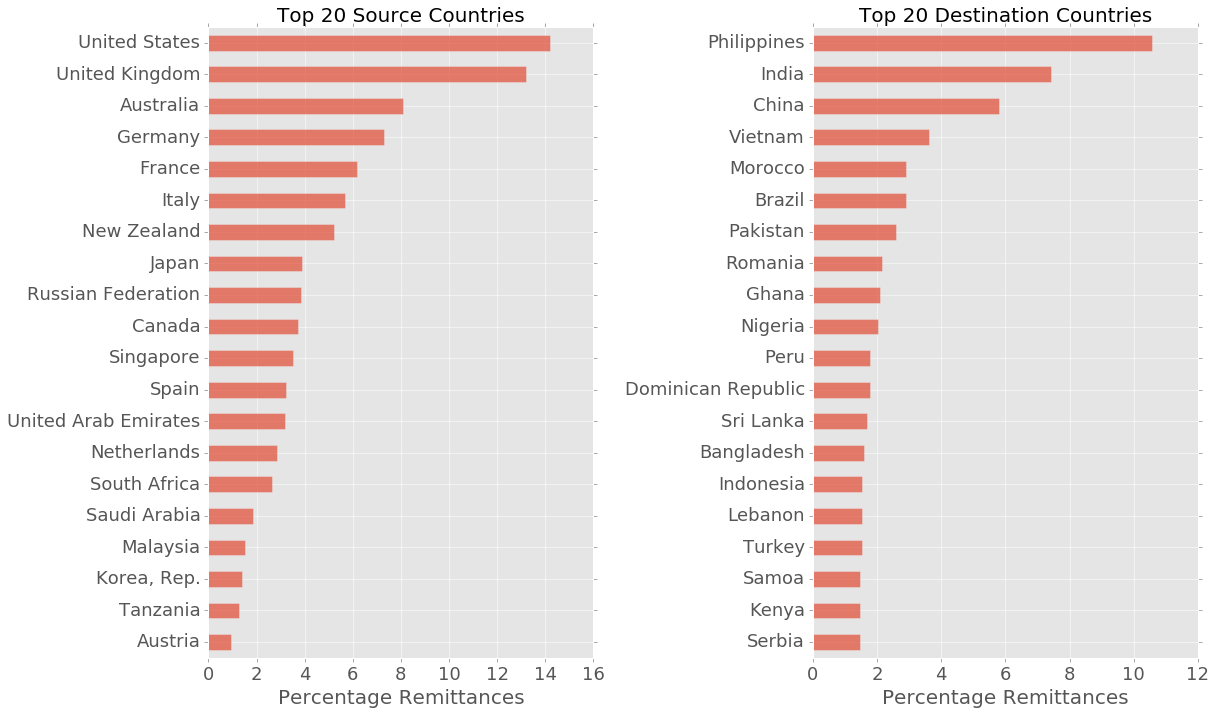

In [23]:
# plotting the data
# for remittance source and destination countries
figsize=[17,10]
fig = plt.figure(figsize=figsize)
opacity=0.7

# plotting source countries
ax = fig.add_subplot(1,2,1)
ax = df1.sort_values(ascending=False).head(20).sort_values().plot(kind='barh',
                                                                  alpha=opacity)
ax.set_ylabel('')
ax.set_xlabel('Percentage Remittances',fontsize=20)
plt.title('Top 20 Source Countries',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting destination countries
ax = fig.add_subplot(1,2,2)
ax = df2.sort_values(ascending=False).head(20).sort_values().plot(kind='barh',
                                                                  alpha=opacity)
ax.set_ylabel('')
ax.set_xlabel('Percentage Remittances',fontsize=20)
plt.title('Top 20 Destination Countries',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

fig.tight_layout(w_pad=2.0, h_pad=2.0)
plt.show()

Lets understand what geographic regions and income groups these countries belong to, and if there's a trend there.

In [24]:
# Source country characteristics
df = df1.sort_values(ascending=False).head(20).reset_index()
pd.merge(left=df, right=df_countries, left_on='source_name',right_on='Country name',how='inner')\
        [['source_name','Income Group','Region']]

,source_name,Income Group,Region
0,United States,High income: OECD,..
1,United Kingdom,High income: OECD,..
2,Australia,High income: OECD,..
3,Germany,High income: OECD,..
4,France,High income: OECD,..
5,Italy,High income: OECD,..
6,New Zealand,High income: OECD,..
7,Japan,High income: OECD,..
8,Russian Federation,High income: nonOECD,..
9,Canada,High income: OECD,..


In [25]:
# Destination country characteristics
df = df2.sort_values(ascending=False).head(20).reset_index()
pd.merge(left=df, right=df_countries, left_on='destination_name',right_on='Country name',how='inner')\
        [['destination_name','Income Group','Region']]

,destination_name,Income Group,Region
0,Philippines,Lower middle income,East Asia & Pacific
1,India,Lower middle income,South Asia
2,China,Upper middle income,East Asia & Pacific
3,Vietnam,Lower middle income,East Asia & Pacific
4,Morocco,Lower middle income,Middle East & North Africa
5,Brazil,Upper middle income,Latin America & Caribbean
6,Pakistan,Lower middle income,South Asia
7,Romania,Upper middle income,Europe & Central Asia
8,Ghana,Lower middle income,Sub-Saharan Africa
9,Nigeria,Lower middle income,Sub-Saharan Africa


The source countries are predominantly *High Income* and destination countries are a good mix of *Lower Middle Income* and *Upper Middle Income* countries. Also, a good fraction (~40%) of the destination countries are *Asian* countries.

## B. Source and destination countries by remittance cost

In [26]:
# Source and destination countries based on overall remittance cost
# these costs are for specific countries averaged over all corridors 
df_cc1_source = df_source['cc1 total cost %'].mean()
df_cc2_source = df_source['cc2 total cost %'].mean()
df_cc1_destination = df_destination['cc1 total cost %'].mean()
df_cc2_destination = df_destination['cc2 total cost %'].mean()

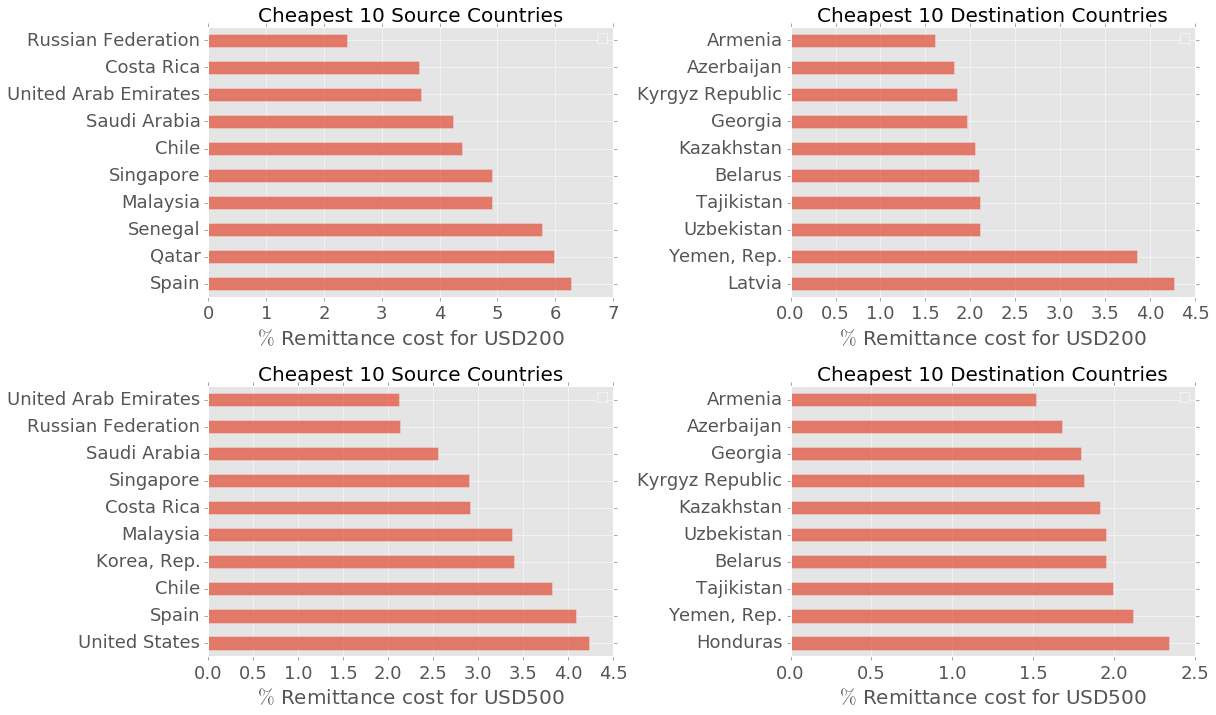

In [27]:
# plotting the data
# for remittance cost 
# based on source and destination countries
figsize=[17,10]
fig = plt.figure(figsize=figsize)
opacity=0.7

# plotting source countries for USD200
ax = fig.add_subplot(221)
ax = df_cc1_source.sort_values()\
                  .head(10).sort_values(ascending=False)\
                  .plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD200',fontsize=20)
plt.title('Cheapest 10 Source Countries',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting destination countries for USD200
ax = fig.add_subplot(222)
ax = df_cc1_destination.sort_values()\
                       .head(10).sort_values(ascending=False)\
                       .plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD200',fontsize=20)
plt.title('Cheapest 10 Destination Countries',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting source countries for USD500
ax = fig.add_subplot(223)
ax = df_cc2_source.sort_values()\
                  .head(10).sort_values(ascending=False)\
                  .plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD500',fontsize=20)
plt.title('Cheapest 10 Source Countries',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting destination countries for USD500
ax = fig.add_subplot(224)
ax = df_cc2_destination.sort_values()\
                       .head(10).sort_values(ascending=False)\
                       .plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD500',fontsize=20)
plt.title('Cheapest 10 Destination Countries',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

fig.tight_layout(w_pad=1.0, h_pad=2.0)
plt.show()

There is some variation in countries for USD200 and USD500, however, they are quite similar. Remittance cost for USD500 is much cheaper than USD200, signalling its cheaper to remit in bulk. Remittance corridors with Armenia as the destination country are probably the cheapest of the lot. Studying remittance corridors is the next step. Before going to that step, however, lets first check the income group of the above countries and geographic region.  

In [28]:
# Income group of source countries for USD500 (cheapest 10)
df = df_cc2_source.sort_values().head(10).reset_index()
pd.merge(left=df, right=df_countries, left_on='source_name',right_on='Country name',how='inner')\
        [['source_name','Income Group','Region']]

,source_name,Income Group,Region
0,United Arab Emirates,High income: nonOECD,..
1,Russian Federation,High income: nonOECD,..
2,Saudi Arabia,High income: nonOECD,..
3,Singapore,High income: nonOECD,..
4,Costa Rica,Upper middle income,Latin America & Caribbean
5,Malaysia,Upper middle income,East Asia & Pacific
6,"Korea, Rep.",High income: OECD,..
7,Chile,High income: OECD,..
8,Spain,High income: OECD,..
9,United States,High income: OECD,..


In [29]:
# Income group of destination countries for USD500 (cheapest 10)
df = df_cc2_destination.sort_values().head(10).reset_index()
pd.merge(left=df, right=df_countries, left_on='destination_name',right_on='Country name',how='inner')\
        [['destination_name','Income Group','Region']]

,destination_name,Income Group,Region
0,Armenia,Lower middle income,Europe & Central Asia
1,Azerbaijan,Upper middle income,Europe & Central Asia
2,Georgia,Lower middle income,Europe & Central Asia
3,Kyrgyz Republic,Lower middle income,Europe & Central Asia
4,Kazakhstan,Upper middle income,Europe & Central Asia
5,Uzbekistan,Lower middle income,Europe & Central Asia
6,Belarus,Upper middle income,Europe & Central Asia
7,Tajikistan,Low income,Europe & Central Asia
8,"Yemen, Rep.",Lower middle income,Middle East & North Africa
9,Honduras,Lower middle income,Latin America & Caribbean


Thus, for these cheaper remmitances, the source countries are predominantly *High Income*. The destination countries are mainly *Lower Middle Income*, and most notably, they are predominantly from *Europe & Central Asia*. This is in contrast with the higher fraction of *Asian* countries in *Sec. A*.

## C. Remittance corridors

In [30]:
# remittance corridors
df_corridors = df_dataset.groupby(['source_name','destination_name'])

In [31]:
# Total number of remittance corridors
df_corridors.size().shape[0]

236

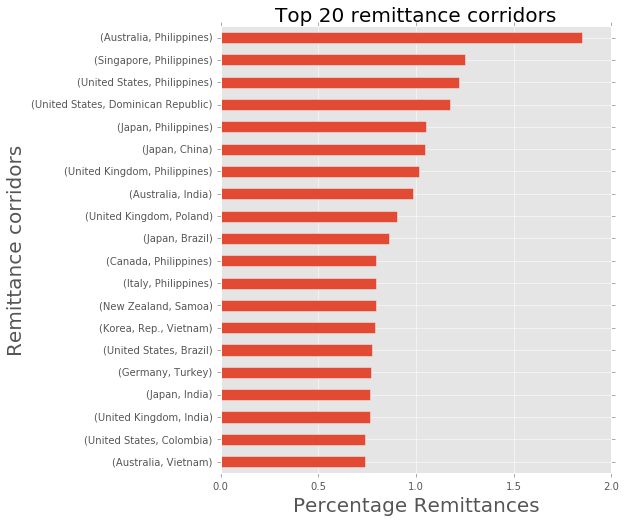

In [32]:
# Top remittance corridors
# in terms of volume of data
# including years 2011-2015
df = df_corridors.size().sort_values(ascending=False)
df = ( df/df.sum() )*100 # convert to percent

# plotting the data
ax = df.head(20).sort_values().plot(kind='barh',figsize=(7,8))
ax.set_xlabel('Percentage Remittances',fontsize=20)
ax.set_ylabel('Remittance corridors',fontsize=20)
ax.set_title('Top 20 remittance corridors',fontsize=20)

In [33]:
# Remittance corridors by cost
df_cc1_corridor = df_corridors[['cc1 total cost %']].mean()
df_cc2_corridor = df_corridors[['cc2 total cost %']].mean()

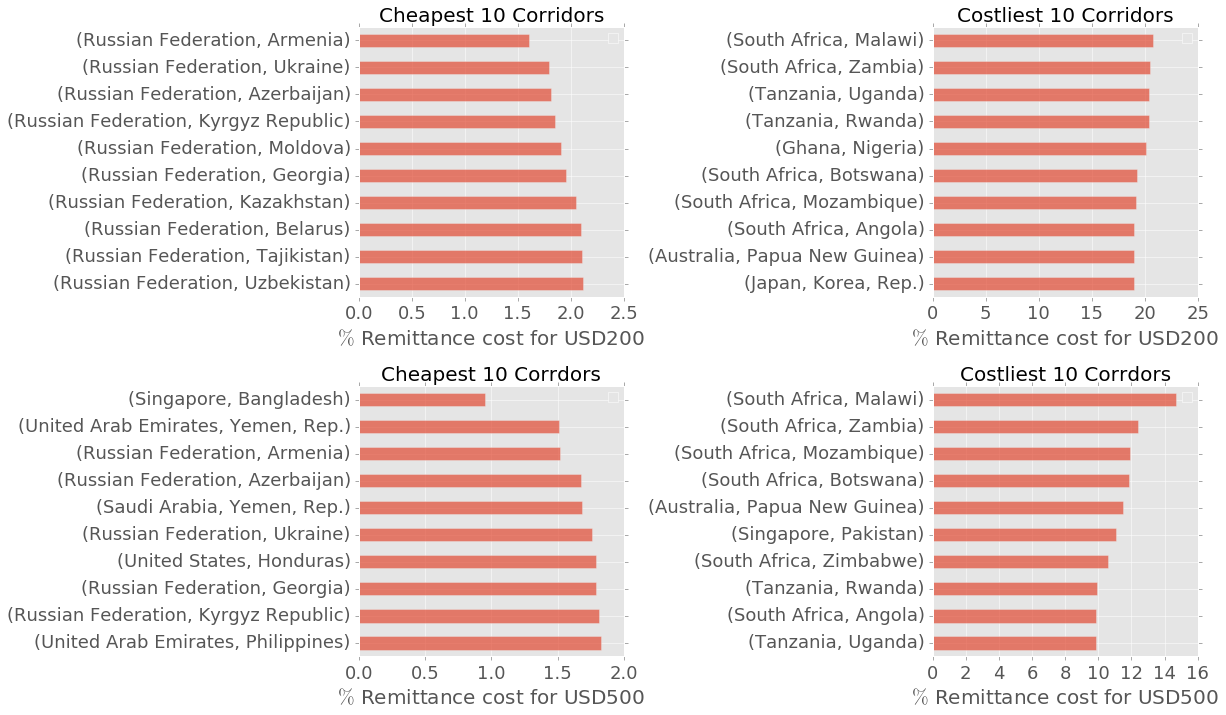

In [34]:
# plotting the data for remittance corridors 
# for USD200 and USD500
figsize=[17,10]
fig = plt.figure(figsize=figsize)
opacity=0.7

# plotting cheaper corridors for USD200
ax = fig.add_subplot(221)
ax = df_cc1_corridor.sort_values('cc1 total cost %')\
                    .head(10).sort_values('cc1 total cost %',ascending=False)\
                    .squeeze().plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD200',fontsize=20)
plt.title('Cheapest 10 Corridors',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting expensive corridors for USD200
ax = fig.add_subplot(222)
ax = df_cc1_corridor.sort_values('cc1 total cost %',ascending=False)\
                    .head(10).sort_values('cc1 total cost %')\
                    .squeeze().plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD200',fontsize=20)
plt.title('Costliest 10 Corridors',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting cheaper corridors for USD500
ax = fig.add_subplot(223)
ax = df_cc2_corridor.sort_values('cc2 total cost %')\
                    .head(10).sort_values('cc2 total cost %',ascending=False)\
                    .squeeze().plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD500',fontsize=20)
plt.title('Cheapest 10 Corrdors',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting most expensive corridors for USD500
ax = fig.add_subplot(224)
ax = df_cc2_corridor.sort_values('cc2 total cost %',ascending=False)\
                    .head(10).sort_values('cc2 total cost %')\
                    .squeeze().plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.legend('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD500',fontsize=20)
plt.title('Costliest 10 Corrdors',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

fig.tight_layout(w_pad=1.0, h_pad=2.0)
plt.show()

In [35]:
# For comparison of the above rates, 
# I provide the mean and std for the remittance costs
cc1_mean = df_dataset['cc1 total cost %'].mean()
cc1_std = df_dataset['cc1 total cost %'].std()
cc2_mean = df_dataset['cc2 total cost %'].mean()
cc2_std = df_dataset['cc2 total cost %'].std()
print 'USD200',(cc1_mean, cc1_std)
print 'USD500',(cc2_mean, cc2_std)

USD200 (8.65276673838746, 6.588614453553728)
USD500 (5.147291871288158, 3.579412144301528)


The cheapest corridors largely involve the *Russian Federation* to *Europe & Central Asia*. This aligns with the previous analysis of source and destination countries with cheapest remittance cost. The highest cost remittance corridors predominantly involve the African countries! For USD500, the most expensive corridor is *South Africa -- Malawi*. The remittance cost for this particular corridor is roughly *3 standard deviations* from the mean remittance cost!

## D. Income categories

In [36]:
df_income = df_dataset.groupby(['source_income','destination_income'])

In [37]:
df_income.size().sort_values(ascending=False)

source_income         destination_income  
High income: OECD     Lower middle income     14765
                      Upper middle income     12342
High income: nonOECD  Lower middle income      3384
High income: OECD     Low income               3227
Upper middle income   Lower middle income      1209
High income: nonOECD  Upper middle income       944
Low income            Low income                786
Upper middle income   Low income                710
High income: nonOECD  Low income                702
High income: OECD     High income: nonOECD      538
                      High income: OECD         535
Upper middle income   Upper middle income       381
High income: nonOECD  High income: nonOECD      150
                      High income: OECD          76
Lower middle income   Lower middle income        63
                      Low income                 41
dtype: int64

Predominant remittances take place between *High Income* and *Upper/Lower Middle Income* countries. They constitute to around 70% of total remittances.

## E. Remittance channel

In [38]:
df_firmtype = df_dataset.groupby('firm_type')

In [39]:
df_cc1_firmtype = df_firmtype['cc1 total cost %'].mean()
df_cc2_firmtype = df_firmtype['cc2 total cost %'].mean()

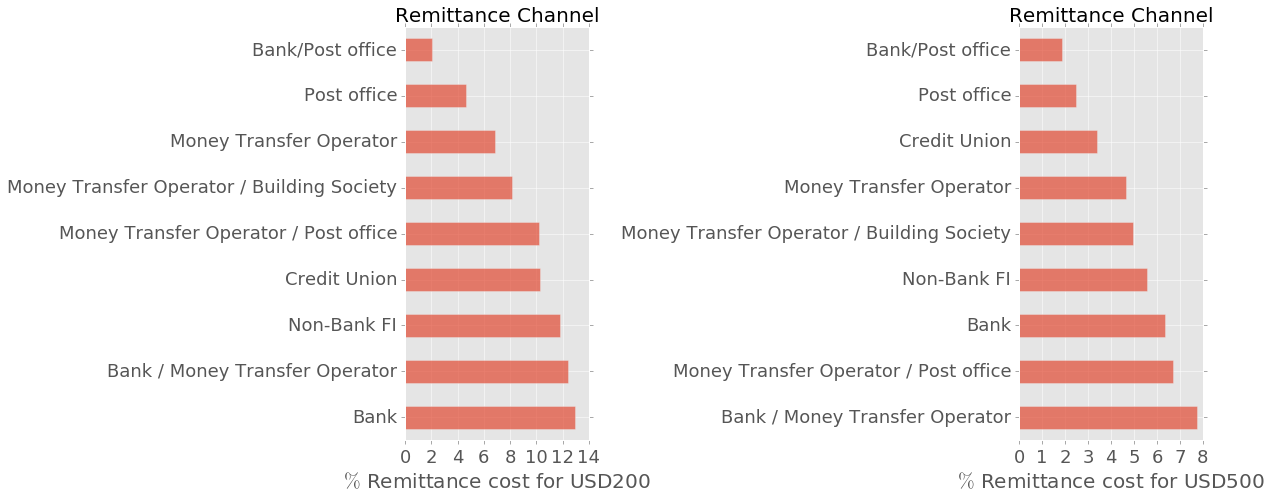

In [40]:
# plotting the data
figsize=[17,7]
fig = plt.figure(figsize=figsize)
opacity=0.7

# plotting source countries
ax = fig.add_subplot(1,2,1)
ax = df_cc1_firmtype.sort_values(ascending=False).plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD200',fontsize=20)
plt.title('Remittance Channel',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting destination countries
ax = fig.add_subplot(1,2,2)
ax = df_cc2_firmtype.sort_values(ascending=False).plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD500',fontsize=20)
plt.title('Remittance Channel',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

fig.tight_layout(w_pad=2.0, h_pad=2.0)
plt.show()

## F. Provider coverage

In [41]:
df_coverage = df_dataset.groupby('coverage')

In [42]:
df_cc1_coverage = df_coverage['cc1 total cost %'].mean()
df_cc2_coverage = df_coverage['cc2 total cost %'].mean()

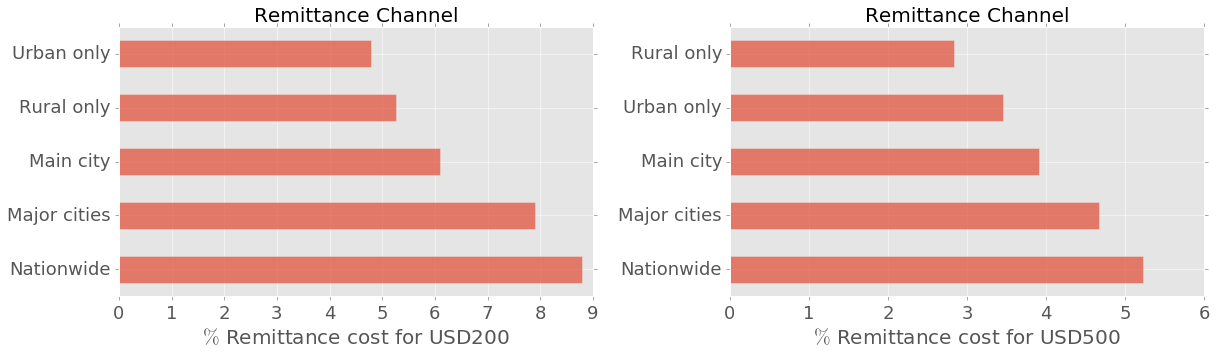

In [43]:
# plotting the data
figsize=[17,5]
fig = plt.figure(figsize=figsize)
opacity=0.7

# plotting source countries
ax = fig.add_subplot(1,2,1)
ax = df_cc1_coverage.sort_values(ascending=False).plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD200',fontsize=20)
plt.title('Remittance Channel',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# plotting destination countries
ax = fig.add_subplot(1,2,2)
ax = df_cc2_coverage.sort_values(ascending=False).plot(kind='barh',alpha=opacity)
ax.set_ylabel('')
ax.set_xlabel(r'$\%$'' Remittance cost for USD500',fontsize=20)
plt.title('Remittance Channel',fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

fig.tight_layout(w_pad=2.0, h_pad=2.0)
plt.show()

# V. Data set trends over the years

## A. US --> India

I will look at specific remittance corridors, such as US-->India, UK-->Poland, etc.  

In [44]:
df_US_India = df_dataset[(df_dataset['source_name']=='United States')\
                         & (df_dataset['destination_name']=='India')]

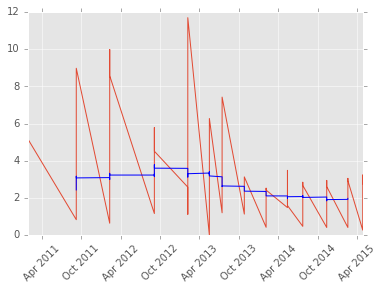

In [45]:
# Trend over the course of 2011-2015
df_US_India_rolling = df_US_India['cc2 total cost %'].rolling(window=50, center=True).mean()
plt.plot(df_US_India['cc2 total cost %'])
plt.plot(df_US_India_rolling, 'b')
plt.xticks(rotation=45)
plt.show()

The remittance cost for US--India corridor has a decreasing trend over the last two years.

## B. UK --> Poland

In [46]:
df_UK_Poland = df_dataset[(df_dataset['source_name']=='United Kingdom')\
                         & (df_dataset['destination_name']=='Poland')]

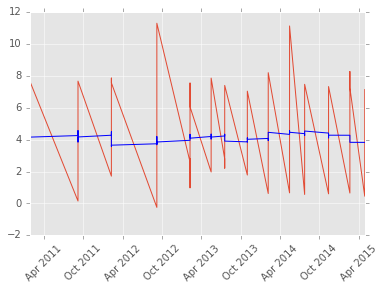

In [47]:
# Trend over the course of 2011-2015
df_UK_Poland_rolling = df_UK_Poland['cc2 total cost %'].rolling(window=50, center=True).mean()
plt.plot(df_UK_Poland['cc2 total cost %'])
plt.plot(df_UK_Poland_rolling, 'b')
plt.xticks(rotation=45)
plt.show()

The overall trend from visual inspection looks nearly stationary.

## C. Russia --> Armenia (cheapest corridor)

In [48]:
df_Russia_Armenia = df_dataset[(df_dataset['source_name']=='Russian Federation')\
                         & (df_dataset['destination_name']=='Armenia')]

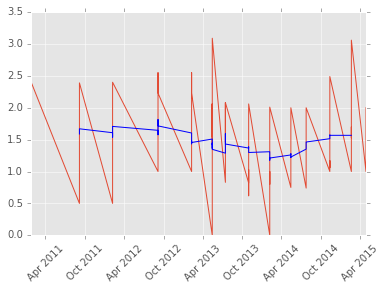

In [49]:
# Trend over the course of 2011-2015
df_Russia_Armenia_rolling = df_Russia_Armenia['cc2 total cost %'].rolling(window=20, center=True).mean()
plt.plot(df_Russia_Armenia['cc2 total cost %'])
plt.plot(df_Russia_Armenia_rolling, 'b')
plt.xticks(rotation=45)
plt.show()

There seems to be an upward trend in remittance cost in recent years. There was a dip in cost in early 2014.

## IV. Australia --> Philippines (Popular)

In [50]:
df_AUS_PH = df_dataset[(df_dataset['source_name']=='Australia')\
                         & (df_dataset['destination_name']=='Philippines')]

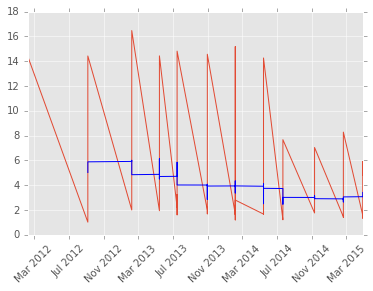

In [51]:
# Trend over the course of 2011-2015
df_AUS_PH_rolling = df_AUS_PH['cc2 total cost %'].rolling(window=70, center=True).mean()
plt.plot(df_AUS_PH['cc2 total cost %'])
plt.plot(df_AUS_PH_rolling, 'b')
plt.xticks(rotation=45)
plt.show()

From visual inspection, the remittance cost is going down over the last couple of years.

# VI. Predictors of remittance prices

## A. Plots and correlations
In this section, I will check what features are the strongest predictors of remittance prices. The analysis will be for the case of USD500. The idea is to first use pearson correlation. I will then use Random Forest to predict remittance cost, and use feature importance to find strongest predictors. 

I will limit the analysis to a subset of features **(source_name, destination_name, firm_type, coverage, cc2 lcu fx rate, cc2 fx margin, cc2 lcu fee)**. Other features such as **sending currency**, **region**, **interbank exchange rate**, etc are strongly correlated with the already chosen features, and hence excluded. 

In [52]:
df_model = df_dataset[['source_name','destination_name','firm_type','coverage',
                       'cc2 lcu fx rate', 'cc2 fx margin','cc2 lcu fee','cc2 total cost %']]
df_model = df_model.dropna().reset_index()

In [53]:
print df_model.shape[0]
df_model.head()

39594


,date,source_name,destination_name,firm_type,coverage,cc2 lcu fx rate,cc2 fx margin,cc2 lcu fee,cc2 total cost %
0,2011-01-24,Australia,Fiji,Money Transfer Operator,Nationwide,1.770000,3.29,10.0,5.29
1,2011-01-24,Australia,Fiji,Money Transfer Operator,Nationwide,1.767737,3.42,12.0,5.82
2,2011-01-24,Australia,Fiji,Money Transfer Operator,Nationwide,1.750000,4.38,15.0,7.38
3,2011-01-24,Australia,Fiji,Bank,Nationwide,1.791400,2.12,20.0,6.12
4,2011-01-24,Australia,Fiji,Bank,Nationwide,1.764200,3.61,20.0,7.61


Lets do some plotting!

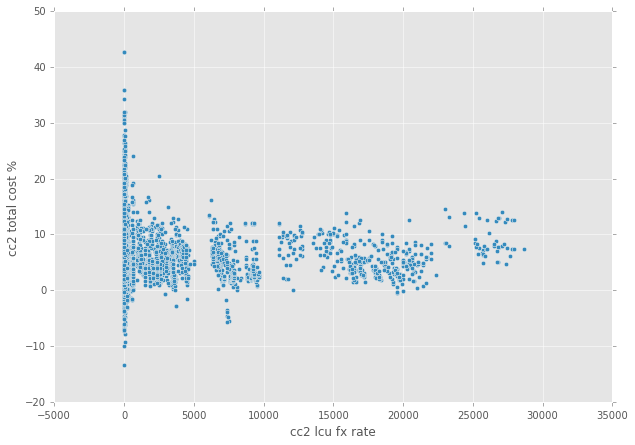

In [54]:
df_model.plot(kind='scatter',y='cc2 total cost %',x='cc2 lcu fx rate',figsize=[10,7])

In [55]:
# correlation between remittance cost and fx rate
df_model['cc2 total cost %'].corr(df_model['cc2 lcu fx rate'],method='pearson')

0.011554758652661723

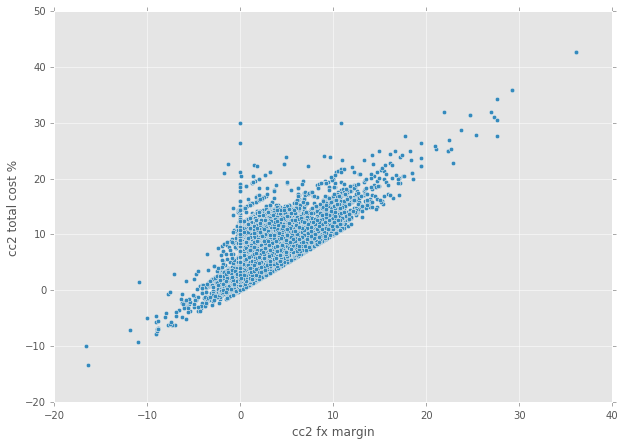

In [56]:
df_model.plot(kind='scatter',y='cc2 total cost %',x='cc2 fx margin',figsize=[10,7])

In [57]:
# correlation between remittance cost and fx margin
df_model['cc2 total cost %'].corr(df_model['cc2 fx margin'],method='pearson')

0.65048153395140385

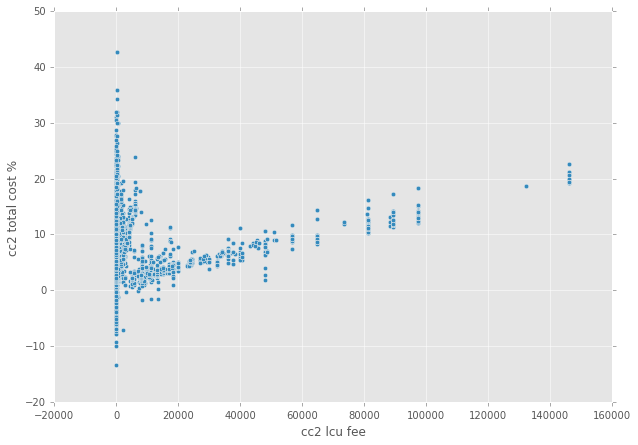

In [58]:
df_model.plot(kind='scatter',y='cc2 total cost %',x='cc2 lcu fee',figsize=[10,7])

In [59]:
# correlation between remittance cost and local fee
df_model['cc2 total cost %'].corr(df_model['cc2 lcu fee'],method='pearson')

0.19085898399970891

From the above analysis, among the numeric features, for remittance cost, **cc2 fx margin** is the strongest predictor followed by **cc2 lcu fee**. Remittance cost is nearly independent of **cc2 lcu fx rate**.

## B. Random Forest 
For Random Forest, I will limit to a smaller subset of categorical features, mainly top 20 (based on number of records) source and destination countries.

In [60]:
# top source countries
# this is a categorical feature
source = df_model.groupby('source_name').size().sort_values(ascending=False).head(20).index
source = source.sort_values()

In [61]:
source

Index([u'Australia', u'Austria', u'Canada', u'France', u'Germany', u'Italy',
       u'Japan', u'Korea, Rep.', u'Malaysia', u'Netherlands', u'New Zealand',
       u'Russian Federation', u'Saudi Arabia', u'Singapore', u'South Africa',
       u'Spain', u'Tanzania', u'United Arab Emirates', u'United Kingdom',
       u'United States'],
      dtype='object', name=u'source_name')

In [62]:
# top destination countries
# this is a categorical feature
destination = df_model.groupby('destination_name').size().sort_values(ascending=False).head(20).index
destination = destination.sort_values()

In [63]:
destination

Index([u'Bangladesh', u'Brazil', u'China', u'Dominican Republic', u'Ghana',
       u'India', u'Indonesia', u'Kenya', u'Lebanon', u'Morocco', u'Nigeria',
       u'Pakistan', u'Peru', u'Philippines', u'Romania', u'Samoa', u'Serbia',
       u'Sri Lanka', u'Turkey', u'Vietnam'],
      dtype='object', name=u'destination_name')

In [64]:
# creating dataframe for prediction using Random Forest 
# the dataframe contains only popular source and destination countries
df_RF = df_model[(df_model.source_name.isin(source) & (df_model.destination_name.isin(destination)))]

In [65]:
df_RF.shape[0]/np.float(df_model.shape[0])

0.5439713087841592

Thus, the popular source and destination countries together account for roughly 55% of the data.

In [66]:
# Here's the data set
df_RF.head()

,date,source_name,destination_name,firm_type,coverage,cc2 lcu fx rate,cc2 fx margin,cc2 lcu fee,cc2 total cost %
37,2011-01-24,Australia,Pakistan,Money Transfer Operator,Nationwide,84.65,0.00,0.0,0.00
38,2011-01-24,Australia,Pakistan,Money Transfer Operator,Nationwide,84.65,0.00,0.0,0.00
39,2011-01-24,Australia,Pakistan,Money Transfer Operator,Nationwide,84.61,0.35,0.0,0.35
40,2011-01-24,Australia,Pakistan,Money Transfer Operator,Nationwide,84.61,0.35,0.0,0.35
41,2011-01-24,Australia,Pakistan,Money Transfer Operator,Nationwide,84.61,0.35,0.0,0.35


In [67]:
# Other categorical features are firm_type and coverge
firm_type = np.unique(df_RF.firm_type)
coverage = np.unique(df_RF.coverage)
print 'firm_type', len(firm_type), firm_type
print ''
print 'coverage', len(coverage), coverage

firm_type 6 [u'Bank' u'Bank / Money Transfer Operator' u'Money Transfer Operator'
 u'Money Transfer Operator / Post office' u'Non-Bank FI' u'Post office']

coverage 5 [u'Main city' u'Major cities' u'Nationwide' u'Rural only' u'Urban only']


In [68]:
# Create dict of source and destination countries
# mapped to integers
num_countries = np.arange(20)
dict_source = {e:v for e,v in zip(source,num_countries)}
dict_destination = {e:v for e,v in zip(destination,num_countries)}

In [69]:
# Create dict of firm_type and coverage
# mapped to integers
num_firm = np.arange(len(firm_type))
num_coverage = np.arange(len(coverage))
dict_firm = {e:v for e,v in zip(firm_type,num_firm)}
dict_coverage = {e:v for e,v in zip(coverage, num_coverage)}

In [70]:
# reformat string columns with dict of integers 
df_RF['source_name'] = df_RF['source_name'].replace(dict_source)
df_RF['destination_name'] = df_RF['destination_name'].replace(dict_destination)
df_RF['firm_type'] = df_RF['firm_type'].replace(dict_firm)
df_RF['coverage'] = df_RF['coverage'].replace(dict_coverage)

# convert columns to categorical dtype
df_RF['source_name'] = df_RF['source_name'].astype('category')
df_RF['destination_name'] = df_RF['destination_name'].astype('category')
df_RF['firm_type'] = df_RF['firm_type'].astype('category')
df_RF['coverage'] = df_RF['coverage'].astype('category')
df_RF.dtypes

/home/pauls/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/pauls/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/pauls/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

date                datetime64[ns]
source_name               category
destination_name          category
firm_type                 category
coverage                  category
cc2 lcu fx rate            float64
cc2 fx margin              float64
cc2 lcu fee                float64
cc2 total cost %           float64
dtype: object

In [71]:
df_RF.head()

,date,source_name,destination_name,firm_type,coverage,cc2 lcu fx rate,cc2 fx margin,cc2 lcu fee,cc2 total cost %
37,2011-01-24,0,11,2,2,84.65,0.00,0.0,0.00
38,2011-01-24,0,11,2,2,84.65,0.00,0.0,0.00
39,2011-01-24,0,11,2,2,84.61,0.35,0.0,0.35
40,2011-01-24,0,11,2,2,84.61,0.35,0.0,0.35
41,2011-01-24,0,11,2,2,84.61,0.35,0.0,0.35


In [72]:
# divide the data set df_RF into train and test set
df_train, df_test = cross_validation.train_test_split(df_RF,
                                                      train_size=0.8,
                                                      random_state=0)

In [73]:
# Random Forest parameters
RF = RandomForestRegressor(n_estimators=50,oob_score=True)

In [74]:
# fit model to train data
RF.fit(df_train.iloc[:,1:8],df_train['cc2 total cost %'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [75]:
# out_of_bag R^2 score
RF.oob_score_

0.98953365311288111

In [76]:
# feature importance
RF.feature_importances_

array([ 0.1057626 ,  0.00373242,  0.00339676,  0.00092392,  0.01908995,
        0.44792634,  0.41916801])

In [77]:
df_train.iloc[:,1:8].columns

Index([u'source_name', u'destination_name', u'firm_type', u'coverage',
       u'cc2 lcu fx rate', u'cc2 fx margin', u'cc2 lcu fee'],
      dtype='object')

In [78]:
for e1, e2 in zip(RF.feature_importances_,df_train.iloc[:,1:8].columns):
    print e1, '    ', e2

0.105762600101      source_name
0.00373242288363      destination_name
0.00339675732374      firm_type
0.000923921166241      coverage
0.0190899477895      cc2 lcu fx rate
0.447926337025      cc2 fx margin
0.419168013711      cc2 lcu fee


Thus, the most important features are **cc2 fx margin** and **cc2 lcu fee**, followed by **source_name**. The other features are not that relevant.

In [79]:
# R^2 score on test data
RF.score(df_test.iloc[:,1:8],df_test['cc2 total cost %'])

0.98960881320230076

# VII. Conclusion

I have analyzed the remittance data based on various features such as remittance corridors, source and destination countries, regions, income groups, remittance channels, and time. The cheapest remittance corridor is the **Europe & Central Asia** corridor, while corridors involving **African** countries are most expensive. The strongest predictors of remittance cost are **foreign exchange margin**, **local currency fee** and **source country names**.

Thanks and Regards,
Saurabh Paul